In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [ ]:
import numpy as np

from scipy.stats import norm

from collections.abc import Callable

def root_bisection(func:Callable, a:float, b:float, epsilon:float=1e-6, log_iter:bool=False):
    """
    Use the bisection method to find the root of a continuous function
    @param func: Objective function
    @param a: Initial bound (a and b must bracket a root, that is f(a)f(b) < 0)
    @param b: Initial bound (a and b must bracket a root, that is f(a)f(b) < 0)
    @param epsilon: convergence tolerance (>0)
    """
    fa = func(a)
    fb = func(b)

    if fa * fb > 0:
        # print(f"Warning: Supplied bounds {a} and {b} do not bracket a root")
        if log_iter:
            return np.nan, np.nan
        else:
            return np.nan
    
    i = 0

    while abs(a - b) > epsilon:
        i += 1
        mid = (a + b) / 2
        fmid = func(mid)

        if fmid == 0:
            a = mid
            break
        elif fa * fmid < 0:
            fb = fmid
            b = mid
        else:
            fa = fmid
            a = mid

    if log_iter:
        return a, i
    else:
        return a


def root_newton(func:Callable, derivative:Callable, x:float, epsilon:float=1e-6, max_iter:int=100, log_iter:bool=False):
    """
    Newton method for root-finding of continuous, differentiable function
    @param func: objective function
    @param derivative: derivative of objective function
    @param x: initial guess
    @param epsilon: convergence tolerance
    @param max_iter: max iterations before giving up
    @param log_iter: Log/output number of iterations to converge
    """

    for i in range(max_iter):
        fx = func(x)
        
        if abs(fx) < epsilon:
            if log_iter:
                return x, i + 1
            else:
                return x
        
        fpx = derivative(x)

        x = x - fx / fpx

    if log_iter:
        return np.nan, np.nan
    else:
        return np.nan
    

if __name__ == "__main__":
    """
    Brief tests for each function
    """
    print(root_bisection(lambda x: (x-2)**3, 0, 5))
    print(root_newton(lambda x: (x-2)**3, lambda x: 3 * (x-2) ** 2, 5))

class BlackScholes:
    @staticmethod
    def _d1_d2(S, K, t, r, sigma):
        """
        d1 and d2 helper function
        """
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        return d1, d2

    @staticmethod
    def call(S, K, t, r, sigma):
        d1, d2 = BlackScholes._d1_d2(S, K, t, r, sigma)
        return S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)

    @staticmethod
    def put(S, K, t, r, sigma):
        d1, d2 = BlackScholes._d1_d2(S, K, t, r, sigma)
        return K * np.exp(-r * t) * norm.cdf(-d2) - S * norm.cdf(-d1)


    @staticmethod
    def delta_call(S, K, t, r, sigma):
        d1, _ = BlackScholes._d1_d2(S, K, t, r, sigma)
        return norm.cdf(d1)

    @staticmethod
    def delta_put(S, K, t, r, sigma):
        d1, _ = BlackScholes._d1_d2(S, K, t, r, sigma)
        return norm.cdf(d1) - 1

    @staticmethod
    def vega(S, K, t, r, sigma):
        d1, _ = BlackScholes._d1_d2(S, K, t, r, sigma)
        return S * norm.pdf(d1) * np.sqrt(t)
    
    @staticmethod
    def gamma(S, K, t, r, sigma):
        d1, _ = BlackScholes._d1_d2(S, K, t, r, sigma)
        return norm.pdf(d1) / (S * sigma * np.sqrt(t))
    
    # finite difference approximations of the greeks
    @staticmethod
    def delta_call_fd(S, K, t, r, sigma, h=0.001):
        up = BlackScholes.call(S + h, K, t, r, sigma)
        down = BlackScholes.call(S - h, K, t, r, sigma)
        return (up - down) / (2 * h)

    @staticmethod
    def delta_put_fd(S, K, t, r, sigma, h=0.001):
        up = BlackScholes.put(S + h, K, t, r, sigma)
        down = BlackScholes.put(S - h, K, t, r, sigma)
        return (up - down) / (2 * h)

    @staticmethod
    def gamma_fd(S, K, t, r, sigma, h=0.001):
        delta_up = BlackScholes.delta_call_fd(S + h, K, t, r, sigma)
        delta_down = BlackScholes.delta_call_fd(S - h, K, t, r, sigma)
        return (delta_up - delta_down) / (h * 2)

    @staticmethod
    def vega_fd(S, K, t, r, sigma, h=0.0001):
        up = BlackScholes.call(S, K, t, r, sigma + h)
        down = BlackScholes.call(S, K, t, r, sigma - h)
        return (up - down) / (2 * h)


    @staticmethod
    def iv_call_bisection(S, K, t, r, mkt_price, log_iter=False):
        # create objective function to find root
        def call_objective(sigma):
            return BlackScholes.call(S, K, t, r, sigma) - mkt_price

        # providing conservative bounds to ensure vol is bracketed
        return root_bisection(call_objective, 0.000001, 20, log_iter=log_iter)

    @staticmethod
    def iv_put_bisection(S, K, t, r, mkt_price, log_iter=False):
        # create objective function to find root
        def put_objective(sigma):
            return BlackScholes.put(S, K, t, r, sigma) - mkt_price

        # providing conservative bounds to ensure vol is bracketed
        return root_bisection(put_objective, 0.000001, 20, log_iter=log_iter)


    @staticmethod
    def iv_call_newton(S, K, t, r, mkt_price, log_iter=False):
        def call_objective(sigma):
            return BlackScholes.call(S, K, t, r, sigma) - mkt_price
        
        def call_derivative(sigma):
            return BlackScholes.vega(S, K, t, r, sigma)
        
        return root_newton(call_objective, call_derivative, 1, log_iter=log_iter)


    @staticmethod
    def iv_put_newton(S, K, t, r, mkt_price, log_iter=False):
        def put_objective(sigma):
            return BlackScholes.put(S, K, t, r, sigma) - mkt_price

        def put_derivative(sigma):
            return BlackScholes.vega(S, K, t, r, sigma)

        return root_newton(put_objective, put_derivative, 1, log_iter=log_iter)
        


if __name__ == "__main__":
    print(BlackScholes.iv_call_bisection(100, 100, 1, 0.05, 10.45, log_iter=True))
    print(BlackScholes.iv_put_bisection(100, 100, 1, 0.05, 5.57))
    print(BlackScholes.iv_call_newton(100, 100, 1, 0.05, 10.45))
    print(BlackScholes.iv_put_newton(100, 100, 1, 0.05, 5.57))

# FE621 Homework 1
Cian Gahan

**<span style="color: red">NOTE</span>:** When setting up and running my data gathering script, I misread the assignment instructions and downloaded option/price data for the SPX index rather than the SPY ETF. I did not realize this until after Thursday's trading hours and therefore could not switch out the data for the correct ticker. I anticipate the results will be very similar. Vol/open interest relative to the contract size being 10x as much seems in line with SPY on yahoo finance when I checked, potentially smaller. I would anticipate liquidity is at worst similar since the granularity of contracts is higher on SPX (every 5 index points at the money, where SPY trades around 1/10th the value and has every $1-spaced options at the money), and SPY mostly does a good job tracking SPX so I don't think this will have a major impact on analysis or results.

Moving forward in the assignment I will use SPX in place of SPY.

## Part 1: Data Gathering Component
### 1.1: Data Gathering Function & Bonus
- See ```scripts/hw1_yf_ingest.py``` for raw ingestion
- See ```scripts/hw1_yf_ingest_cleaner.py``` for cleaning/combination
### 1.2:
- Why do additional maturities exist? Given that TSLA, SPX, and VIX are all highly liquid, popular tickers with a lot of speculative interest, traders have demand for products that speculate on volatility/short term movements with finer control over the time window than the traditional monthly schedule, especially as the maturity date approaches. Therefore exchanges/market makers introduce options with more maturities as these dates approach, meeting demand without fragmenting long-term maturity liquidity (eg a month or two out, weekly options may be introduced, and a week or so out, daily options may be introduced in the case of SPX).

In [2]:
# load in options and price data
options = pd.read_csv("../data/cleaned/options.csv", index_col=0)
print(options.head())

       contractSymbol  strike   bid   ask optionType  expiration underlying  \
0  VIX260218C00010000    10.0  9.75  10.4       call  2026-02-18       ^VIX   
1  VIX260218C00010500    10.5  9.25   9.9       call  2026-02-18       ^VIX   
2  VIX260218C00011000    11.0  8.75   9.4       call  2026-02-18       ^VIX   
3  VIX260218C00011500    11.5  8.25   8.9       call  2026-02-18       ^VIX   
4  VIX260218C00012000    12.0  7.75   8.4       call  2026-02-18       ^VIX   

    data_date  daysToMaturity  underlyingPrice  fedFunds  
0  2026-02-12               6        19.879999    0.0364  
1  2026-02-12               6        19.879999    0.0364  
2  2026-02-12               6        19.879999    0.0364  
3  2026-02-12               6        19.879999    0.0364  
4  2026-02-12               6        19.879999    0.0364  


### 1.3:
- SPX: Index published by S&P consisting of a market-cap weighted average of ~500 of the largest companies trading in the US stock market. Purpose is to provide a measure of overall US stock market performance
- SPY: ETF that tracks the SPX index, managed by State Street. Purpose is to gain easy exposure to the entire US stock market
- VIX: Index published by CBOE that estimates 30 day market-implied volatility using a weighted combination of implied volatilities calculated from out-of-the-money SPX call and put options between 23 and 37 days to maturity. Purpose is to provide a measure for expected volatility and allow for trading/speculation on it directly
- TSLA: Tesla Stock. Purpose is to invest in Tesla
- Example option symbol decomposition: 
    * TICKERYYMMDD{C/P}STRIKE (strike listed as XXXXX.XXX fixed-point)
    * eg TSLA260220C00450000 - tesla call maturing on Feb 20th with strike $450.
    * Note on SPX options: Options may be listed with tickers as SPX or SPXW in raw data. SPXW are typically found in the finer-grain weekly maturities but may also exist at certain prices in the traditional maturity dates. The mechanical difference is that SPXW expire/are settled using VWAP near the end of the trading day on Friday, while SPX expire at the opening auction on Friday. To simplify analysis I removed this distinction while cleaning the data and am measuring time to maturity as the number of days

### 1.4:
- For short term interest rate I used the Fed Funds (effective) rate from the Fed website which was 3.64% for both days in my data

## Part 2: Analysis of the Data
### 2.5:
- Black-Scholes Implementation: See ```FE621/pricing/black_scholes.py```
### 2.6:
- Bisection Method: See ```FE621/utils.py```
- Note: I found that implied volatility would not converge for much of the options (could not find clear pattern and option quotes seemed off from intrinsic value when checked so presumably stale quotes/data issue) so I replaced non converging values with nan here

In [3]:
def row_iv(row):
    if row["optionType"] == "call":
        return BlackScholes.iv_call_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )
    else:
        return BlackScholes.iv_put_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )

options["impliedVolatilityB"] = options.apply(row_iv, axis=1)

In [4]:
options["moneyness"] = options["underlyingPrice"] / options["strike"]
options["abs_moneyness"] = (options["underlyingPrice"] - options["strike"]).abs()

def timeval(row):
    if row["optionType"] == "call":
        return (row["bid"] + row["ask"]) / 2 - np.max(row["underlyingPrice"] - row["strike"], 0)
    else:
        return (row["bid"] + row["ask"]) / 2 - np.max(row["strike"] - row["underlyingPrice"], 0)

options["timeval"] = options.apply(timeval, axis=1)

data1 = options[options["data_date"] == "2026-02-12"]

spx_first = data1[(data1["underlying"] == "^SPX") & (data1["expiration"] == "2026-02-20")]
tsla_first = data1[(data1["underlying"] == "TSLA") & (data1["expiration"] == "2026-02-20")]

spx_atm = spx_first[spx_first["abs_moneyness"] == spx_first["abs_moneyness"].min()]
tsla_atm = tsla_first[tsla_first["abs_moneyness"] == tsla_first["abs_moneyness"].min()]

spx_range_atm = spx_first[(spx_first["moneyness"] >= 0.95) & (spx_first["moneyness"] <= 1.05)]
tsla_range_atm = tsla_first[(tsla_first["moneyness"] >= 0.95) & (tsla_first["moneyness"] <= 1.05)]

spx_atm_iv = spx_atm["impliedVolatilityB"].mean()
tsla_atm_iv = tsla_atm["impliedVolatilityB"].mean()

spx_range_atm_iv = spx_range_atm["impliedVolatilityB"].mean()
tsla_range_atm_iv = tsla_range_atm["impliedVolatilityB"].mean()

print("SPX at the money: " + str(spx_atm_iv))
print("SPX around the money: " + str(spx_range_atm_iv))
print("TSLA: " + str(tsla_atm_iv))
print("TSLA around the money: " + str(tsla_range_atm_iv))

SPX at the money: 0.16649494394962489
SPX around the money: 0.16960305650260124
TSLA: 0.41606047321558
TSLA around the money: 0.42085042494567787


### 2.7:
- Newton Method: See ```FE621/utils.py```

In [5]:
def row_iv_newton(row):
    if row["optionType"] == "call":
        return BlackScholes.iv_call_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )
    else:
        return BlackScholes.iv_put_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2
        )

options["impliedVolatilityN"] = options.apply(row_iv_newton, axis=1)

/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  x = x - fx / fpx
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: overflow encountered in scalar divide
  x = x - fx / fpx


In [6]:
print("Maximum ivol difference (Bisection vs Newton): " + str((options["impliedVolatilityB"] - options["impliedVolatilityN"]).abs().max()))

Maximum ivol difference (Bisection vs Newton): 1.441229731091731e-05


We can see that the implied volatility converges to essentially the same values for both newton and bisection methods

In [7]:
def iter_bisection(row):
    if row["optionType"] == "call":
        _, i = BlackScholes.iv_call_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter = True
        )
        return i
    else:
        _, i = BlackScholes.iv_put_bisection(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter = True
        )
        return i

def iter_newton(row):
    if row["optionType"] == "call":
        _, i = BlackScholes.iv_call_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter=True
        )
        return i
    else:
        _, i = BlackScholes.iv_put_newton(
            row["underlyingPrice"], 
            row["strike"], 
            row["daysToMaturity"] / 365, 
            np.log1p(row["fedFunds"]), 
            (row["bid"] + row["ask"]) / 2,
            log_iter=True
        )
        return i

iters_bisection = options.apply(iter_bisection, axis=1)
iters_newton = options.apply(iter_newton, axis=1)

/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  x = x - fx / fpx
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/pricing/black_scholes.py:13: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
/Users/ciangahan/Documents/Stevens/FE621/FE621/utils.py:68: RuntimeWarning: overflow encountered in scalar divide
  x = x - fx / fpx


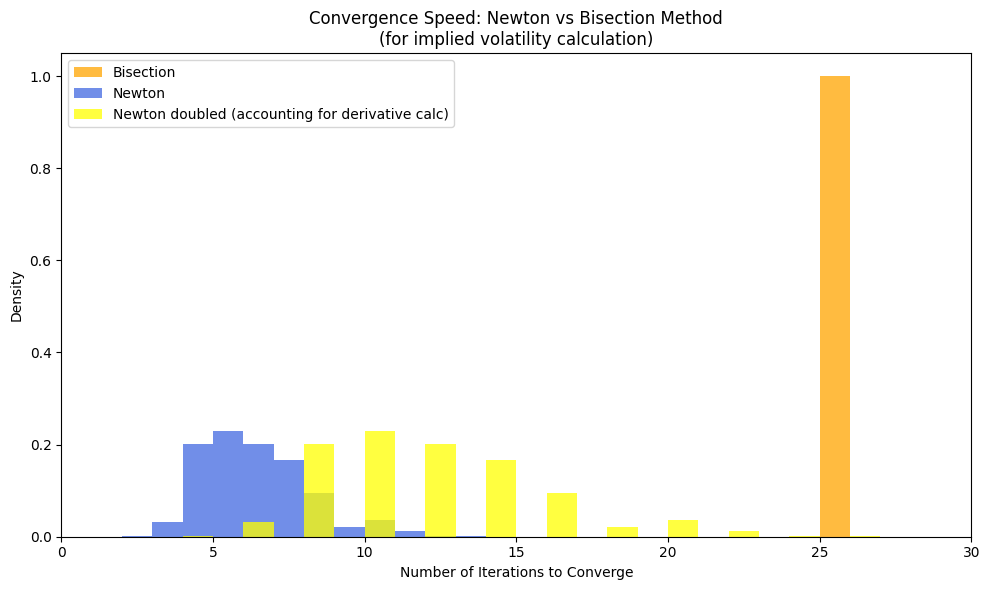

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(iters_bisection,
        bins=np.arange(0, 30, 1),
        alpha=0.75,
        label='Bisection',
        color='orange',
        density=True)

ax.hist(iters_newton[iters_newton != 100],
        bins=np.arange(0, 30, 1),
        alpha=0.75,
        label='Newton',
        color='royalblue',
        density=True)

ax.hist(iters_newton[iters_newton * 2 <= 100] * 2,
        bins=np.arange(0, 30, 1),
        alpha=0.75,
        label='Newton doubled (accounting for derivative calc)',
        color='yellow',
        density=True)

ax.set_xlabel('Number of Iterations to Converge')
ax.set_ylabel('Density')
ax.set_title('Convergence Speed: Newton vs Bisection Method\n(for implied volatility calculation)')

ax.legend()
ax.set_xlim(0, 30)

plt.tight_layout()
plt.show()

The Newton method clearly converges faster with essentially all cases below 15 iterations, even though it has more variability than bisection. The bisection iterations are constant since the initial interval is the same, binary search within a certain tolerance should take the same number of iterations, validating the result. Shrinking the bisection interval to a less conservative estimate of implied volatility would not likely change the results by much, as the interval could be halved or quartered but this would only speed up by 1-2 iterations given the halving nature of the algorithm. It is worth noting the Newton method requires derivative calculations which double the computations per iteration, but even after doubling the iterations to account for this, the distribution still clearly outperforms bisection.

### 2.8:
- To avoid skewing results with high OTM/ITM implied vols, I used the same moneyness thresholds from earlier for each stock/option type/maturity combination and averaged the results of each category's range for the table. I am using the bisection implied volatilities here

In [23]:
data1_atm = data1[(data1["moneyness"] >= 0.95) & (data1["moneyness"] <= 1.05) & (data1["underlying"] != "^VIX")].dropna()
avg_ivs = data1_atm.groupby(
    ['expiration', 'optionType', 'underlying'],
    as_index=False
)['impliedVolatilityB'].mean()
avg_ivs

,expiration,optionType,underlying,impliedVolatilityB
0,2026-02-20,call,TSLA,0.430960
1,2026-02-20,call,^SPX,0.170339
2,2026-02-20,put,TSLA,0.410741
3,2026-02-20,put,^SPX,0.168539
4,2026-03-20,call,TSLA,0.445434
5,2026-03-20,call,^SPX,0.168052
6,2026-03-20,put,TSLA,0.434499
7,2026-03-20,put,^SPX,0.159492
8,2026-04-17,call,TSLA,0.455664
9,2026-04-17,call,^SPX,0.166487


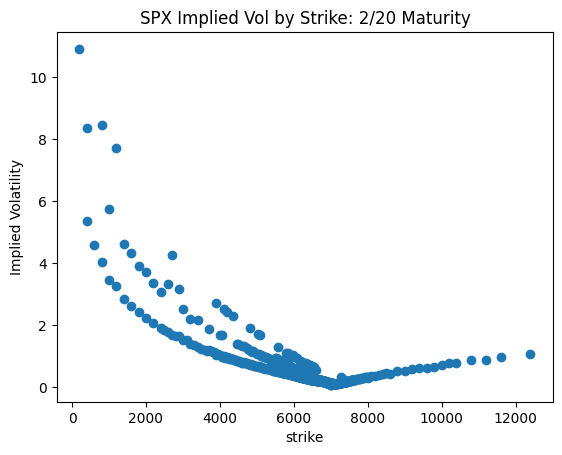

In [25]:
plt.scatter(spx_first["strike"], spx_first["impliedVolatilityB"])
plt.xlabel("strike")
plt.ylabel("Implied Volatility")
plt.title("SPX Implied Vol by Strike: 2/20 Maturity")
plt.show()

We can see that the implied volatility for TSLA options is consistently significantly higher than that of SPX, around 43-45% on average compared to 16-17%. As the maturity increases, the implied volatility for SPX options decreases slightly while TSLA options seem not to exhibit much of a pattern; both are relatively stable. We can see from the data (illustrated with an example of SPX 2/20 maturity options above) that the implied vol increases (sometimes significantly) as the option moves further from at the money in either direction. We can also see that the implied volatility of SPX options is lower than the current VIX value (16-17% vs 0.19-0.2) for all maturities, which could indicate an issue in my data or implied volatility calculations (as SPX options within this three-month window are used to calculate the VIX).

### 2.9:
- To save time I just aggregated all options with a corresponding pair using a left join on a call-filtered version of the dataframe and calculated put-call parity for each

In [26]:
data1.head()

,contractSymbol,strike,bid,ask,optionType,expiration,underlying,data_date,daysToMaturity,underlyingPrice,fedFunds,impliedVolatilityB,moneyness,abs_moneyness,timeval
0,VIX260218C00010000,10.0,9.75,10.4,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,3.590312,1.988000,9.879999,0.195001
1,VIX260218C00010500,10.5,9.25,9.9,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,3.370347,1.893333,9.379999,0.195001
2,VIX260218C00011000,11.0,8.75,9.4,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,3.160400,1.807273,8.879999,0.195001
3,VIX260218C00011500,11.5,8.25,8.9,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,2.959408,1.728696,8.379999,0.195001
4,VIX260218C00012000,12.0,7.75,8.4,call,2026-02-18,^VIX,2026-02-12,6,19.879999,0.0364,2.766438,1.656667,7.879999,0.195001


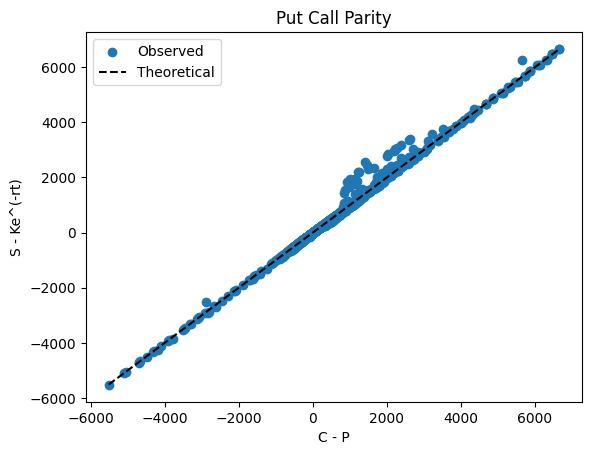

In [43]:
calls = data1[data1["optionType"] == "call"]
calls["midprice"] = (calls["bid"] + calls["ask"]) / 2
puts = data1[data1["optionType"] == "put"]
puts["midprice"] = (puts["bid"] + puts["ask"]) / 2
matched = pd.merge(calls, puts, how="inner", on=["strike", "underlying", "expiration"])[["strike", "expiration", "underlying", "midprice_x", "midprice_y", "daysToMaturity_x", "underlyingPrice_x", "fedFunds_x"]]
matched = matched.rename(columns={"midprice_x": "call_price", "midprice_y": "put_price", "daysToMaturity_x": "daysToMaturity", "underlyingPrice_x": "underlyingPrice", "fedFunds_x": "fedFunds"})
matched["parity"] = matched["underlyingPrice"] - matched["strike"] * np.exp(-matched["fedFunds"] * matched["daysToMaturity"] / 365)

plt.scatter(matched["call_price"] - matched["put_price"], matched["parity"], label="Observed")
plt.plot(
    np.linspace(min(matched["call_price"] - matched["put_price"]), max(matched["call_price"] - matched["put_price"])),
    np.linspace(min(matched["call_price"] - matched["put_price"]), max(matched["call_price"] - matched["put_price"])), "k--", label="Theoretical"
)
plt.xlabel("C - P")
plt.ylabel("S - Ke^(-rt)")
plt.title("Put Call Parity")
plt.legend()
plt.show()

We can see that most of the option values roughly track with what is expected in put-call parity, though there are some near the money (where the stock price is slightly above the discounted strike) that have a higher than expected C - P difference. This could be due to them being American options or potential issues with the data (delays between stock price and option prices, stale quotes etc)

### 2.10:
- Using SPX options here for the (ostensibly) best result as asset is not specified. I believe there is a data issue causing puts to have negative time value at a certain strike above the money, hence the dropoff and disappearance of those 
- For the cross-maturity comparison I chose to just use calls to avoid confusion in the chart with six different series (or with different-shaped implied vol curves). I recognize this might be a data issue and not be relevant in practice but in this case I think it improves the quality of the chart

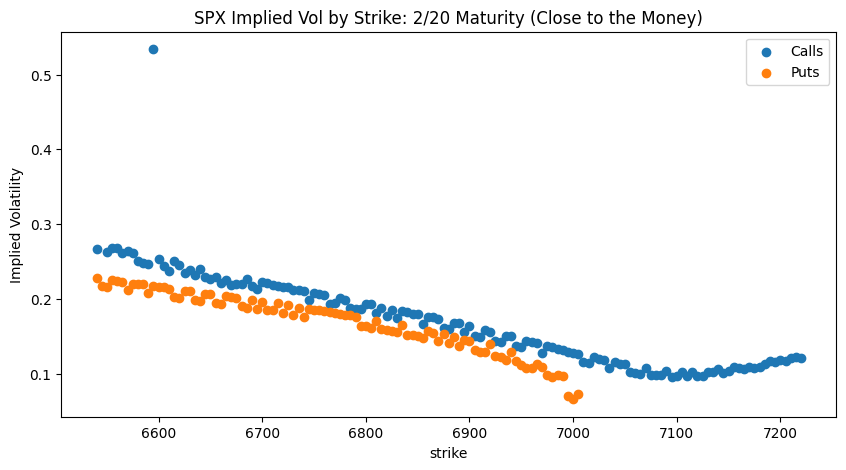

In [56]:
spx_first_atm = spx_first[(spx_first["moneyness"] >= 0.95) & (spx_first["moneyness"] <= 1.05)]
plt.figure(figsize=(10,5))
plt.scatter(spx_first_atm[spx_first_atm["optionType"] == "call"]["strike"], spx_first_atm[spx_first_atm["optionType"] == "call"]["impliedVolatilityB"], label="Calls")
plt.scatter(spx_first_atm[spx_first_atm["optionType"] == "put"]["strike"], spx_first_atm[spx_first_atm["optionType"] == "put"]["impliedVolatilityB"], label="Puts")
plt.xlabel("strike")
plt.ylabel("Implied Volatility")
plt.title("SPX Implied Vol by Strike: 2/20 Maturity (Close to the Money)")
plt.legend()
plt.show()

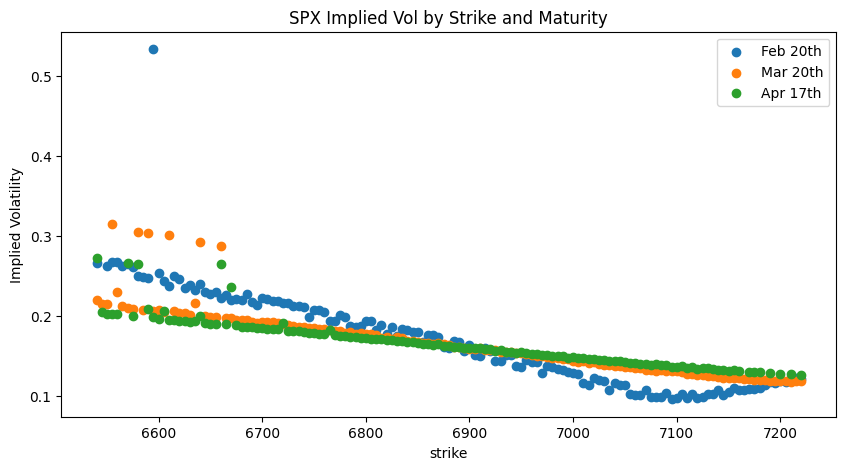

In [60]:
spx_atm = data1_atm[(data1_atm["underlying"] == "^SPX") & (data1_atm["optionType"] == "call")]
plt.figure(figsize=(10,5))
plt.scatter(spx_atm[spx_atm["expiration"] == "2026-02-20"]["strike"], spx_atm[spx_atm["expiration"] == "2026-02-20"]["impliedVolatilityB"], label="Feb 20th")
plt.scatter(spx_atm[spx_atm["expiration"] == "2026-03-20"]["strike"], spx_atm[spx_atm["expiration"] == "2026-03-20"]["impliedVolatilityB"], label="Mar 20th")
plt.scatter(spx_atm[spx_atm["expiration"] == "2026-04-17"]["strike"], spx_atm[spx_atm["expiration"] == "2026-04-17"]["impliedVolatilityB"], label="Apr 17th")
plt.xlabel("strike")
plt.ylabel("Implied Volatility")
plt.title("SPX Implied Vol by Strike and Maturity")
plt.legend()
plt.show()

### Bonus:

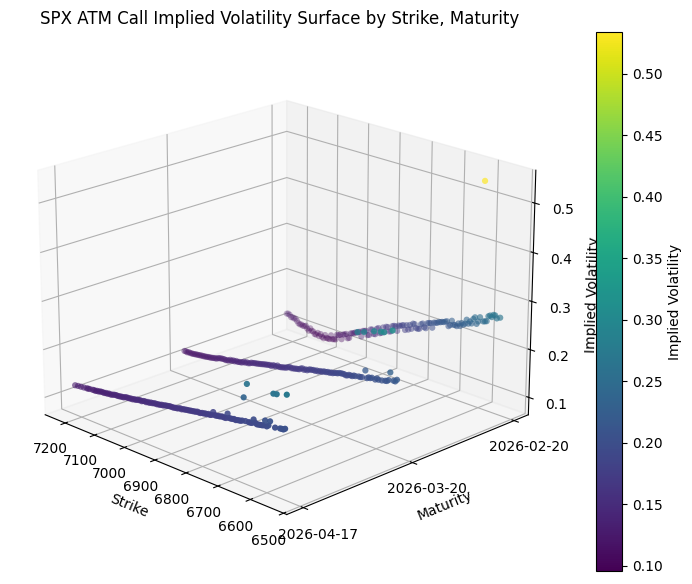

In [85]:
maturities = ['2026-02-20', '2026-03-20', '2026-04-17']

# need to swap maturity strings for numbers so it will show on the chart
maturity_to_idx = {mat: i for i, mat in enumerate(maturities)}
spx_atm["mat_idx"] = spx_atm["expiration"].map(maturity_to_idx)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# will use colors with colorbar for better interpretability (hard to read otherwise)
sc = ax.scatter(
    spx_atm["strike"],
    spx_atm["mat_idx"],
    spx_atm["impliedVolatilityB"],
    c=spx_atm["impliedVolatilityB"],
    cmap='viridis',
    edgecolor='none'
)

ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_zlabel("Implied Volatility")

ax.set_yticks(range(len(maturities)))
ax.set_yticklabels(maturities)

ax.set_title("SPX ATM Call Implied Volatility Surface by Strike, Maturity")

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Implied Volatility")

# tilting the chart to see all points
ax.view_init(elev=20, azim=135)

ax.grid()
plt.show()

### 2.11:
- See ```FE621/pricing/black_scholes.py``` for implementation (includes theoretical and finite difference approximation)

In [ ]:
# TODO: choose options subset to calculate greeks on; compare results for each

### 2.12:
- I used an inner join to add all existing data1 implied vols onto data2 using merge function, discarding data2 entries where data1 implied vol didn't converge. From there I used black-scholes and fetched remaining params from data2

In [ ]:
def calc_price(row):
    if row["optionType"] == "call":
        return BlackScholes.call(row["underlyingPrice"], row["strike"], row["daysToMaturity"] / 365, row["fedFunds"], row["impliedVolatility"])
    else:
        return BlackScholes.put(row["underlyingPrice"], row["strike"], row["daysToMaturity"] / 365, row["fedFunds"], row["impliedVolatility"])

data2 = pd.merge(options[options["data_date"] == "2026-02-13"], data1[["contractSymbol", "impliedVolatilityB"]], how="inner", on="contractSymbol")
data2 = data2.rename(columns={"impliedVolatilityB_y": "impliedVolatility"})
data2["midprice"] = (data2["bid"] + data2["ask"]) / 2
data2["calcprice"] = data2.apply(calc_price, axis=1)
data2.head()

,contractSymbol,strike,bid,ask,optionType,expiration,underlying,data_date,daysToMaturity,underlyingPrice,fedFunds,impliedVolatilityB_x,moneyness,abs_moneyness,timeval,impliedVolatilityN,impliedVolatility,midprice,calcprice
0,VIX260218C00010000,10.0,9.5,10.1,call,2026-02-18,^VIX,2026-02-13,5,19.280001,0.0364,4.990807,1.928000,9.280001,0.519999,NaN,3.590312,9.8,9.430322
1,VIX260218C00010500,10.5,9.0,9.6,call,2026-02-18,^VIX,2026-02-13,5,19.280001,0.0364,4.690863,1.836191,8.780001,0.519999,NaN,3.370347,9.3,8.932530
2,VIX260218C00011000,11.0,8.5,9.1,call,2026-02-18,^VIX,2026-02-13,5,19.280001,0.0364,4.404801,1.752727,8.280001,0.519999,NaN,3.160400,8.8,8.434926
3,VIX260218C00011500,11.5,8.0,8.6,call,2026-02-18,^VIX,2026-02-13,5,19.280001,0.0364,4.131056,1.676522,7.780001,0.519999,NaN,2.959408,8.3,7.937537
4,VIX260218C00012000,12.0,7.5,8.1,call,2026-02-18,^VIX,2026-02-13,5,19.280001,0.0364,3.868258,1.606667,7.280001,0.519999,NaN,2.766438,7.8,7.440394


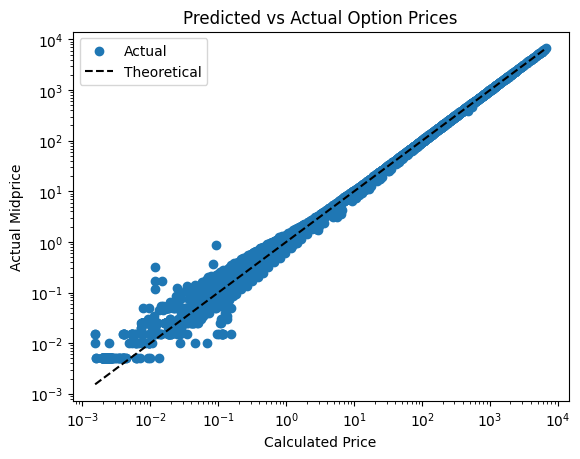

In [76]:
plt.scatter(data2["calcprice"], data2["midprice"], label="Actual")
plt.plot(
    np.linspace(min(data2["calcprice"]), max(data2["calcprice"])),
    np.linspace(min(data2["calcprice"]), max(data2["calcprice"])), "k--", label="Theoretical"
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Calculated Price")
plt.ylabel("Actual Midprice")
plt.title("Predicted vs Actual Option Prices")
plt.legend()
plt.show()

I used a log-log plot to better zoom in on differences between options with lower prices as these are the most sensitive/potentially interesting. It appears the calculated prices did a decent job of predicting what the actual prices would end up as, but there were still notable discrepancies, particularly for lower-priced options. Implied volatility likely changed for many of these options day-to-day.

## Part 3: Numerical Integration of AMM Arbitrage Fee Revenue

Note volatility = 0.2, fee rate = 0.003

P_{t+1} = \frac{y_t - \Delta y}{x_t + (1 - \gamma)\Delta x} = S_{t+1}(1-\gamma)

I will begin with Case 1. First solving for $\Delta x$:

$$
\begin{align}
(x_t + (1 - \gamma)\Delta x)(y_t - \Delta y) = k \\
(x_t + (1 - \gamma)\Delta x) = \frac{k}{(y_t - \Delta y)} \\
(1 - \gamma)\Delta x = \frac{k}{(y_t - \Delta y)} - x_t \\
\Delta x = (\frac{k}{(y_t - \Delta y)} - x_t)(1 - \gamma)
\end{align}
$$

Next, solving for $\Delta y$ and plugging in for $\Delta x$:
$$
\begin{align}
\frac{y_t - \Delta y}{x_t + (1 - \gamma)\Delta x} = S_{t+1}(1-\gamma) \\
\frac{y_t - \Delta y}{x_t + (1 - \gamma)^2(\frac{k}{(y_t - \Delta y)} - x_t)} = S_{t+1}(1-\gamma) \\
\frac{(y_t - \Delta y)}{x_t(1 - (1 - \gamma)^2) + \frac{k(1 - \gamma)^2}{(y_t - \Delta y)}} = S_{t+1}(1-\gamma) \\
\frac{(y_t - \Delta y)^2}{x_t(1 - (1 - \gamma)^2)(y_t - \Delta y) + k(1 - \gamma)^2} = S_{t+1}(1-\gamma) \\
(y_t - \Delta y)^2 = S_{t+1}(1-\gamma)(x_t(1 - (1 - \gamma)^2)(y_t - \Delta y) + k(1 - \gamma)^2) \\
(y_t - \Delta y)^2 - S_{t+1}(1-\gamma)x_t(1 - (1 - \gamma)^2)(y_t - \Delta y) - S_{t+1}k(1 - \gamma)^3 = 0\\
\end{align}
$$


Using the quadratic formula:
$$
\begin{align}
y_t - \Delta y = \frac{S_{t+1}(1-\gamma)x_t(1 - (1 - \gamma)^2) \pm \sqrt{(S_{t+1}(1-\gamma)x_t(1 - (1 - \gamma)^2))^2+4S_{t+1}k(1 - \gamma)^3}}{2}
\end{align}
$$
Since $y_{t+1} > 0$ and the inside of the square root is greater than the first term in the fraction numerator, we can discard the minus as extraneous solution:

$$
\begin{align}
\Delta y = y_t - \frac{S_{t+1}(1-\gamma)x_t(1 - (1 - \gamma)^2) + \sqrt{(S_{t+1}(1-\gamma)x_t(1 - (1 - \gamma)^2))^2+4S_{t+1}k(1 - \gamma)^3}}{2} \\
\end{align}
$$


Next Case 2. Can find $\Delta x$ as function of above $\Delta y$:

Was unable to finish this section on time unfortunately

## Part 4 Bonus: Numerical Integration

$$
\begin{align}
f_1(x, y) = xy
f_2(x, y) = e^{x + y}
\end{align}
$$

### 4.1: Analytically solve the following integral for f_1 and f_2:
$$
\begin{align}
I_1 = \int_{0}^{1} \left( \int_{0}^{3} xy \, dy \right) dx \\
= \int_{0}^{1} x \left[ \frac{y^2}{2} \right]_{0}^{3} dx \\
= \int_{0}^{1} x \cdot \frac{9}{2} \, dx \\
= \frac{9}{2} \int_{0}^{1} x \, dx \\
= \frac{9}{2} \left[ \frac{x^2}{2} \right]_{0}^{1} \\
= \frac{9}{2} \cdot \frac{1}{2} = \dfrac{9}{4} \\
I_2 = \int_{0}^{1} \int_{0}^{3} e^{x+y} \, dy dx \\
= \int_{0}^{1} e^{x} \int_{0}^{3} e^{y} \, dy dx \\
= \int_{0}^{1} e^{x} \left[ e^{y} \right]_{0}^{3} dx \\
= \int_{0}^{1} e^{x} (e^3 - e^0) \, dx \\
= (e^3 - 1) \int_{0}^{1} e^{x} \, dx \\
= (e^3 - 1) \left[ e^{x} \right]_{0}^{1} \\
= (e^3 - 1) (e^1 - e^0) \\
= (e^3 - 1)(e - 1)
\end{align}
$$

In [87]:
print("First Integral: " + str(9/4))
print("Second Integral: " + str((np.exp(3) - 1)*(np.exp(1) - 1)))

First Integral: 2.25
Second Integral: 32.79433128149753


Was unable to finish this section on time, which would have included debugging the below function (which has some syntax issue presumably)

In [89]:
def trapezoid_integrate(f, x0, x1, n, y0, y1, m):
    dx = (x1 - x0) / n
    dy = (y1 - y0) / m

    # set up discrete points
    x = np.linspace(x0, x1, n + 1)
    y = np.linspace(y0, y1, m + 1)

    res = 0

    for xi in x:
        for yi in y:
            res += dx * dy / 16 * (f(xi, yi) + f(xi, yi + dy) + f(xi + dx, yi) + f(xi + dx, yi + dy) + 
                                   2*(f(xi + dx/2, yi) + f(xi + dx/2, yi + dy) + f(xi, yi + dy/2) + f(xi + dx, yi + dy/2)) + 
                                   4*f(x+dx/2, y+dy/2))

    return res

In [90]:
def f1(x, y):
    return x * y

def f2(x, y):
    return np.exp(x + y)

In [91]:
pairs = [(10, 10), (50, 50), (100, 100), (500, 500)]

for pair in pairs:
    n, m = pair
    print("First Integral Approx: " + str(trapezoid_integrate(f1, 0, 1, n, 0, 3, m)))
    print("Second Integral Approx: " + str(trapezoid_integrate(f2, 0, 1, n, 0, 3, m)))

First Integral Approx: [2.477475 2.531925 2.640825 2.804175 3.021975 3.294225 3.620925 4.002075
 4.437675 4.927725 5.472225]
Second Integral Approx: [40.52234749 41.06749729 41.88076524 43.09401845 44.90397956 47.60412423
 51.63226675 57.64154924 66.60634528 79.98024941 99.9317699 ]
First Integral Approx: [1.82683836 1.82871108 1.83245652 1.83807468 1.84556556 1.85492916
 1.86616548 1.87927452 1.89425628 1.91111076 1.92983796 1.95043788
 1.97291052 1.99725588 2.02347396 2.05156476 2.08152828 2.11336452
 2.14707348 2.18265516 2.22010956 2.25943668 2.30063652 2.34370908
 2.38865436 2.43547236 2.48416308 2.53472652 2.58716268 2.64147156
 2.69765316 2.75570748 2.81563452 2.87743428 2.94110676 3.00665196
 3.07406988 3.14336052 3.21452388 3.28755996 3.36246876 3.43925028
 3.51790452 3.59843148 3.68083116 3.76510356 3.85124868 3.93926652
 4.02915708 4.12092036 4.21455636]
Second Integral Approx: [27.8501885  27.91782964 27.99110442 28.07048204 28.15647079 28.24962129
 28.35053002 28.45984315 